<a href="https://colab.research.google.com/github/ralitsa-k/Analysis_of_eye_tracking/blob/main/Complete_Model_(ML%2BLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'small-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5484622%2F9089247%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T032650Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03025d87365bc9bdadf6d210b5ec80be124e12be3e71810e5e078b46e37785236e524f607cac792945cbab8aa52bf6a5524c5c33e2c7a76a4de7e6e31835430fdeed6961d5aa39ae5129b7c7319989daa70c0f9099bfdbb9d30de7369fcaf7f8a8163cef9cbc8afb05c12eae837d1cfdc390bce0c92459a0e83f7be866a7714adbe8b9e44045c05733295f8a914948acd7400eead655b6b8f539230ef686cd785032b8ac583a17728c9581a9b8cf627af61cbbb8d3b3cb9af35164c86ea19631b61c6b79b911969a0f0933fe1815cb1b50f9460f744c1d84c126e393eb992ac5be82e4f12d69ecc87b001caabda88176634c774cbb3216477e1846238be1194a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import polars as pl
from datetime import time
import glob

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn import set_config
import warnings
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/small-data/Week2.csv
/kaggle/input/small-data/Week1.csv


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")

print('found GPU at:{}'.format(device_name))
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

2024-08-12 03:20:35.298504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 03:20:35.298627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 03:20:35.421758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


found GPU at:/device:GPU:0
GPU available


In [ ]:
w1 = pl.read_csv('/kaggle/input/small-data/Week1.csv')
w2 = pl.read_csv('/kaggle/input/small-data/Week2.csv')
#w1.glimpse()
#w2.glimpse()

c = pl.concat([w1,w2])
c = c.drop("","RecordType","ActivityID","TimePeriodID")
c.glimpse()

Rows: 483840
Columns: 7
$ ChannelID  <i64> 50, 50, 30, 50, 30, 50, 50, 50, 50, 30
$ TargetID   <i64> 3, 7, 6, 16, 1, 21, 3, 28, 17, 1
$ Time       <str> '10:50', '10:30', '10:00', '13:25', '18:30', '24:20', '11:55', '16:55', '06:20', '10:10'
$ UnitID     <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ UnitValue  <f64> 33.0, 124.0, 305.4, 41.6, 96.2, 77.1, 16.9, 60.0, 0.0, 69.6
$ DayOfWeek  <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ WeekNumber <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



In [ ]:
views = c.filter(pl.col('UnitID')==1)
share = c.filter(pl.col('UnitID')==3)
tvr = c.filter(pl.col('UnitID')==6)

views_1 = views.with_columns([pl.col('UnitValue').alias('Views')]).drop(['UnitID','UnitValue'])
share_1 = share.with_columns([pl.col('UnitValue').alias('Share')]).drop(['UnitID','UnitValue'])
tvr_1 = tvr.with_columns([pl.col('UnitValue').alias('TVR')]).drop(['UnitID','UnitValue'])

views_1.glimpse()
share_1.glimpse()
tvr_1.glimpse()

c1 = views_1.join(share_1, on = ['ChannelID', 'TargetID','Time','DayOfWeek','WeekNumber'], how = 'left')
c1.glimpse()

c2 = c1.join(tvr_1, on = ['ChannelID', 'TargetID','Time','DayOfWeek','WeekNumber'], how = 'left')
c2.glimpse()

Rows: 161280
Columns: 6
$ ChannelID  <i64> 50, 50, 30, 50, 30, 50, 50, 50, 50, 30
$ TargetID   <i64> 3, 7, 6, 16, 1, 21, 3, 28, 17, 1
$ Time       <str> '10:50', '10:30', '10:00', '13:25', '18:30', '24:20', '11:55', '16:55', '06:20', '10:10'
$ DayOfWeek  <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ WeekNumber <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ Views      <f64> 33.0, 124.0, 305.4, 41.6, 96.2, 77.1, 16.9, 60.0, 0.0, 69.6

Rows: 161280
Columns: 6
$ ChannelID  <i64> 50, 30, 50, 30, 30, 50, 50, 50, 30, 30
$ TargetID   <i64> 26, 4, 11, 10, 26, 28, 29, 3, 26, 24
$ Time       <str> '20:45', '23:10', '18:20', '12:50', '08:30', '15:55', '24:00', '22:40', '08:45', '20:35'
$ DayOfWeek  <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ WeekNumber <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ Share      <f64> 8.0505, 8.2545, 2.0881, 20.3898, 19.6031, 4.7444, 0.0, 6.1472, 20.3731, 18.2574

Rows: 161280
Columns: 6
$ ChannelID  <i64> 50, 50, 30, 50, 50, 30, 50, 30, 50, 30
$ TargetID   <i64> 20, 16, 27, 16, 20, 25, 4, 4, 24, 4
$ T

In [ ]:
cm = c2.to_pandas()

cmf = cm[(cm['Share']>=0) & (cm['Views']>=0) & (cm['TVR']>=0)]
#cmf.info()

X= cmf.drop(columns=["Views"])
y= cmf["Views"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

train_pd = pd.concat([X_train, y_train], axis = 1)

#List of categorical variables to one hot encode

cat = ["TargetID","ChannelID","DayOfWeek","WeekNumber"]
train_pd_num = train_pd.drop(cat, axis = 1)

stats = train_pd_num.describe()
stats = stats.loc[['max','min','mean','std']]
stats = stats.transpose()

print('Descriptive statistics of numerical variables')
print('  ')
print(stats)

Descriptive statistics of numerical variables
  
             max  min        mean         std
Share   104.1666  0.0   10.001726   10.280491
TVR      15.4109  0.0    0.966175    1.550568
Views  5231.2000  0.0  193.997968  388.658825


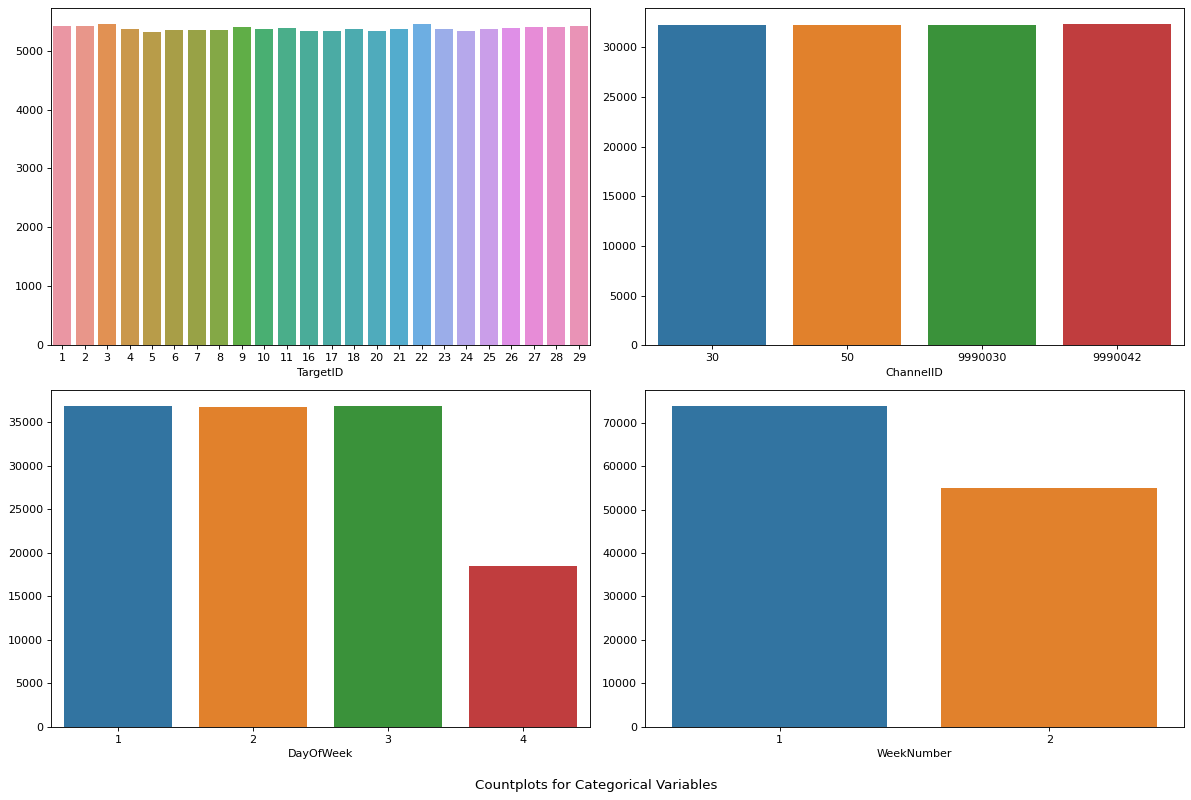

In [ ]:
fig, axes = plt.subplots(figsize = (15,10), ncols = 2, nrows = 2)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.countplot(data=train_pd, x = cat[i], ax=ax)
    ax.set_ylabel("")
    if i ==len(cat)-1:
        break
plt.suptitle("Countplots for Categorical Variables", y = -0.01, fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
ohe = OneHotEncoder(drop = 'if_binary')

#One hot encode selected columns and preserve feature names
encoded = ohe.fit_transform(train_pd[cat])

encoded_cols = ohe.get_feature_names_out(cat)

#Deleting one hot encoded variables and other cols from train data set
del_col = cat + ["Time"]

train_pd_reduced = train_pd.drop(del_col, axis = 1)

#Converting ohe cols to padnas
encoded_col_df = pd.DataFrame(encoded.todense(), columns = encoded_cols, index = train_pd_reduced.index)

#Merge ohe variables and numerical variables to create correlation matrix
encoded_train_df = pd.concat([train_pd_reduced,encoded_col_df],axis=1)

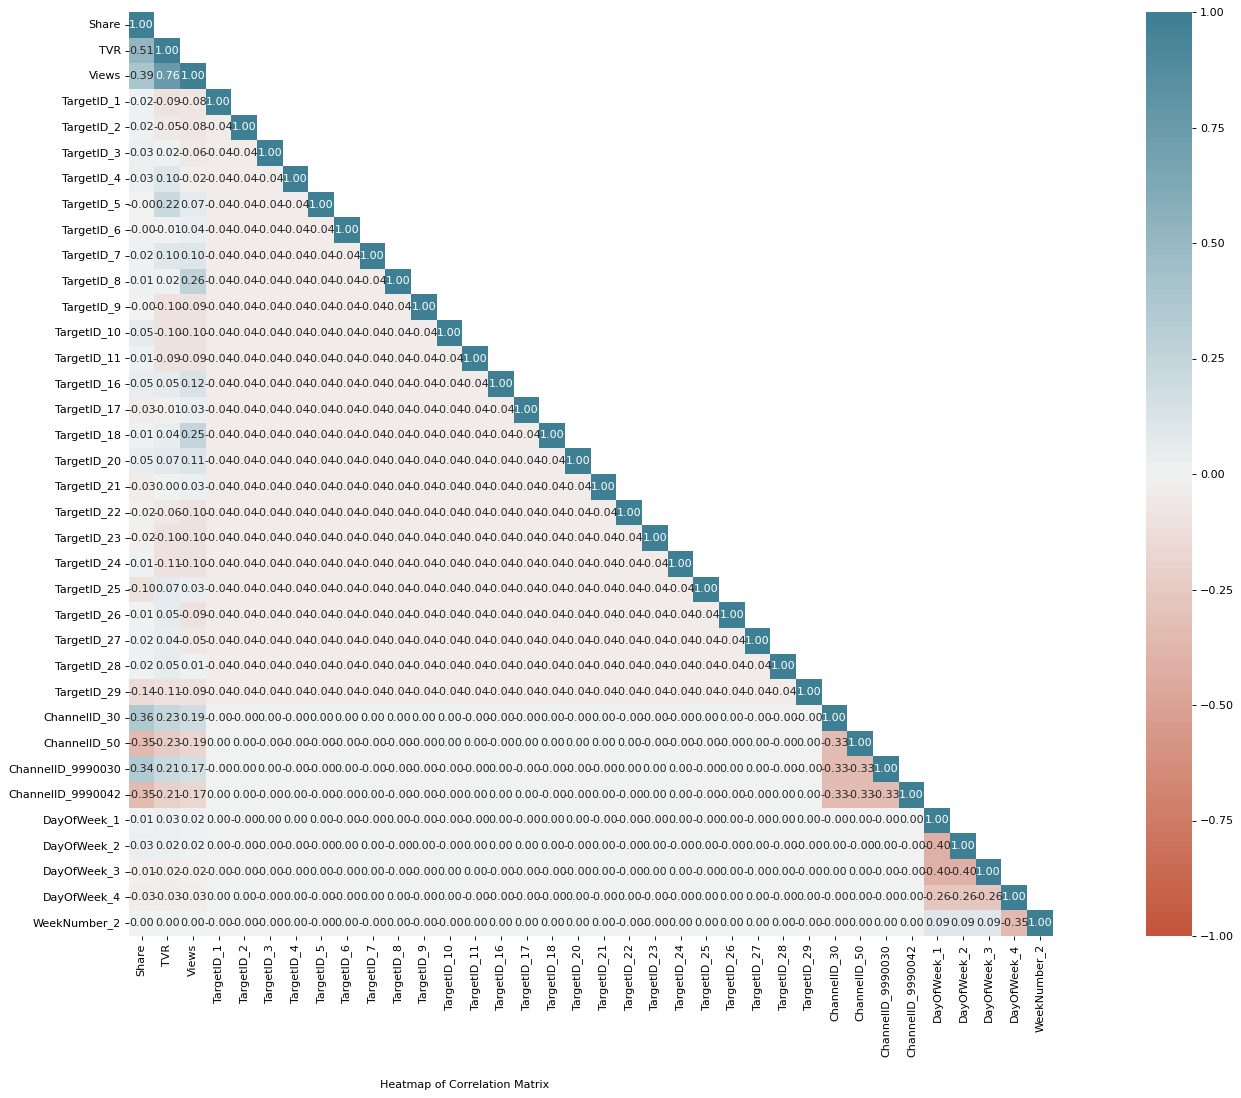

In [ ]:
corr_m = encoded_train_df.corr()

f, ax = plt.subplots(figsize=(30,15))

mask = np.triu(np.ones_like(corr_m, dtype=bool), k = 1)

sns_plot = sns.heatmap(corr_m,
                      mask = mask,
                      annot = True,
                      fmt = '.2f',
                      vmin = -1, vmax = 1, center = 0,
                      cmap = sns.diverging_palette(20,220,n=200),
                      square=True)
plt.suptitle("Heatmap of Correlation Matrix", y = -0.01, fontsize=10)
plt.show()

# Vanilla Model
## 1. Linear Regression

In [ ]:
columns_to_drop = ["Time"]
catf = ["TargetID","ChannelID","DayOfWeek","WeekNumber"]
numf = ["Share","TVR"]

#Preprocessing pipeline

prep = ColumnTransformer(
    transformers =[
            ("drop_columns", "drop", columns_to_drop),
            ("cat", OneHotEncoder(),catf),
            ("num", StandardScaler(),numf)
        ])

steps1=[
    ("preprocessor", prep),
    ("lr", LinearRegression())
]

set_config(display="diagram")

lr_pipe = Pipeline(steps1)

lr_pipe.fit(X_train,y_train)

y_pred1 = lr_pipe.predict(X_test)

MSE = mean_squared_error(y_test,y_pred1)
RMSE = np.sqrt(MSE)
Rsqr = r2_score(y_test, y_pred1)

print(f'R2-score: {Rsqr}')
print(f'Mean squared error: {MSE}')
print(f'RMSE:{RMSE}')

lr_pipe

R2-score: 0.7516055210164346
Mean squared error: 38738.64474093379
RMSE:196.82135235012942


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Time']),
                                                 ('cat', OneHotEncoder(),
                                                  ['TargetID', 'ChannelID',
                                                   'DayOfWeek', 'WeekNumber']),
                                                 ('num', StandardScaler(),
                                                  ['Share', 'TVR'])])),
                ('lr', LinearRegression())])

In [ ]:
def rrse(y_true, y_pred):
    # Calculate the mean of the actual values
    y_mean = np.mean(y_true)

    # Calculate the Residual Sum of Squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)

    # Calculate the Total Sum of Squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)

    # Calculate RRSE
    rrse_value = np.sqrt(rss / tss)

    return rrse_value

rrse_lr = rrse(y_test, y_pred1)
print(f'Root Relative Squared Error of Linear Reg Model: {rrse_lr}')

Root Relative Squared Error of Linear Reg Model: 0.4983918929753626


In [ ]:
'''
from math import log
def calculate_aic(n, mse, num_params):
 aic = 2 * num_params -  2* n * log(mse)
 return aic

np1 = len(lr_pipe['lr'].coef_)+1

print(lr_pipe['lr'].coef_)
print(np1)

aic_lr = calculate_aic(len(y_test),MSE,np1)
print(f'AIC of Linear Regression Model :{aic_lr}')
'''

"\nfrom math import log\ndef calculate_aic(n, mse, num_params):\n aic = 2 * num_params -  2* n * log(mse)\n return aic\n\nnp1 = len(lr_pipe['lr'].coef_)+1\n\nprint(lr_pipe['lr'].coef_)\nprint(np1)\n\naic_lr = calculate_aic(len(y_test),MSE,np1)\nprint(f'AIC of Linear Regression Model :{aic_lr}')\n"

In [ ]:
'''
def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic

BIC_lr = calculate_bic(len(y_test), MSE, np1)
print('BIC: %.3f' %BIC_lr)
'''

"\ndef calculate_bic(n, mse, num_params):\n bic = n * log(mse) + num_params * log(n)\n return bic\n\nBIC_lr = calculate_bic(len(y_test), MSE, np1)\nprint('BIC: %.3f' %BIC_lr)\n"

In [ ]:
import xgboost
from xgboost import XGBRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import plot_tree

## 2. Decision Tree Model

In [ ]:
dt_pipe = Pipeline(steps=[
    ("preprocessor",prep),
    ("dec_tree",DecisionTreeRegressor())
])

dt_pipe.fit(X_train,y_train)
y_pred2 = dt_pipe.predict(X_test)

MSE2 = mean_squared_error(y_test,y_pred2)
RMSE2 = np.sqrt(MSE2)
Rsqr2 = r2_score(y_test, y_pred2)
RRSE_DT = rrse(y_test, y_pred2)

print(f'R2-score: {Rsqr2}')
print(f'Mean squared error: {MSE2}')
print(f'RMSE:{RMSE2}')
print(f'RRSE:{RRSE_DT}')

dt_pipe

R2-score: 0.9998044790249586
Mean squared error: 30.492697029825756
RMSE:5.522019289157342
RRSE:0.01398288149993897


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Time']),
                                                 ('cat', OneHotEncoder(),
                                                  ['TargetID', 'ChannelID',
                                                   'DayOfWeek', 'WeekNumber']),
                                                 ('num', StandardScaler(),
                                                  ['Share', 'TVR'])])),
                ('dec_tree', DecisionTreeRegressor())])

In [ ]:
#np2 = len(dt_pipe['dec_tree'].coef_)+1
#AIC_dt = calculate_aic(len(y_test),MSE2,np2)
#BIC_dt = calculate_bic(len(y_test),MSE2,np2)
#print(AIC_dt)
#print(BIC_dt)

              Feature    Importance
35                TVR  6.573067e-01
7          TargetID_8  1.048117e-01
13        TargetID_18  1.033188e-01
20        TargetID_26  2.856155e-02
11        TargetID_16  1.564983e-02
14        TargetID_20  1.263291e-02
3          TargetID_4  1.100662e-02
34              Share  1.051561e-02
21        TargetID_27  1.040329e-02
2          TargetID_3  6.482958e-03
12        TargetID_17  6.237034e-03
5          TargetID_6  6.190675e-03
6          TargetID_7  5.609118e-03
4          TargetID_5  5.060801e-03
22        TargetID_28  4.572403e-03
15        TargetID_21  3.612275e-03
19        TargetID_25  2.767052e-03
16        TargetID_22  2.759308e-03
1          TargetID_2  2.048827e-03
0          TargetID_1  2.117670e-04
17        TargetID_23  7.517074e-05
23        TargetID_29  5.042456e-05
33       WeekNumber_2  4.975512e-05
18        TargetID_24  3.447688e-05
9         TargetID_10  1.532328e-05
26  ChannelID_9990030  6.588438e-06
27  ChannelID_9990042  2.911

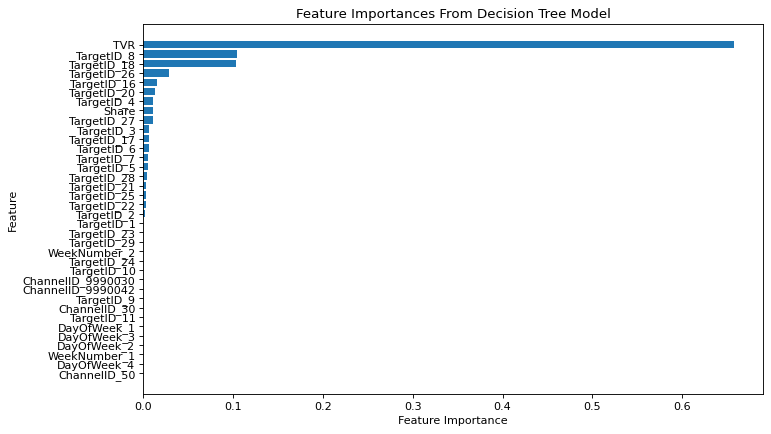

In [ ]:
prep1 = dt_pipe.named_steps['preprocessor']
fit_reg = dt_pipe.named_steps['dec_tree']

cat_feat = prep1.transformers_[1][2]
num_feat = prep1.transformers_[2][2]

enc2 = prep1.named_transformers_['cat']
enc_cat_feat1 = enc2.get_feature_names_out(cat_feat)

feat = list(enc_cat_feat1)+list(num_feat)
imp = fit_reg.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature':feat,
    'Importance':imp
})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
print(feat_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances From Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

## 3. XGBoost Model

In [ ]:
xgb = XGBRegressor(eval_metric='rmse')
xgb_pipe = Pipeline(
        steps= [
        ("preprocessor",prep),
        ("regressor",xgb)
            ])

param_grid = {"regressor__max_depth":    [4, 5, 6],
              "regressor__n_estimators": [500, 600, 700],
              "regressor__learning_rate": [0.01, 0.015]}

search = GridSearchCV(xgb_pipe, param_grid, cv=5)

search.fit(X_train,y_train)

#y_pred3= xgb_pipe.predict(X_test)

#MSE3 = mean_squared_error(y_test,y_pred3)
#RMSE3 = np.sqrt(MSE3)
#Rsqr3 = r2_score(y_test, y_pred3)

#print(f'R2-score: {Rsqr3}')
#print(f'Mean squared error: {MSE3}')
#print(f'RMSE:{RMSE3}')

#xgb_pipe
print("The best hyperparameters are ",search.best_estimator_)

The best hyperparameters are  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Time']),
                                                 ('cat', OneHotEncoder(),
                                                  ['TargetID', 'ChannelID',
                                                   'DayOfWeek', 'WeekNumber']),
                                                 ('num', StandardScaler(),
                                                  ['Share', 'TVR'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=N

In [ ]:
y_pred3 = search.best_estimator_.predict(X_test)
MSE3 = mean_squared_error(y_test,y_pred3)
RMSE3 = np.sqrt(MSE3)
Rsqr3 = r2_score(y_test, y_pred3)
RRSE_XG = rrse(y_test, y_pred3)

print(f'R2-score: {Rsqr3}')
print(f'Mean squared error: {MSE3}')
print(f'RMSE:{RMSE3}')
print(f'RRSE:{RRSE_XG}')

R2-score: 0.9979928807741679
Mean squared error: 313.02257183964895
RMSE:17.692443919358595
RRSE:0.04480088420814967


              Feature  Importance
13        TargetID_18    0.222726
7          TargetID_8    0.200874
20        TargetID_26    0.115042
11        TargetID_16    0.059727
21        TargetID_27    0.057665
14        TargetID_20    0.048811
3          TargetID_4    0.048673
2          TargetID_3    0.043537
35                TVR    0.043028
5          TargetID_6    0.029133
6          TargetID_7    0.026292
12        TargetID_17    0.023710
16        TargetID_22    0.022832
4          TargetID_5    0.020734
15        TargetID_21    0.014401
1          TargetID_2    0.009300
22        TargetID_28    0.003044
17        TargetID_23    0.002482
10        TargetID_11    0.001851
19        TargetID_25    0.001525
34              Share    0.001490
9         TargetID_10    0.001159
18        TargetID_24    0.000913
0          TargetID_1    0.000367
32       WeekNumber_1    0.000157
23        TargetID_29    0.000131
31        DayOfWeek_4    0.000092
28        DayOfWeek_1    0.000086
30        DayO

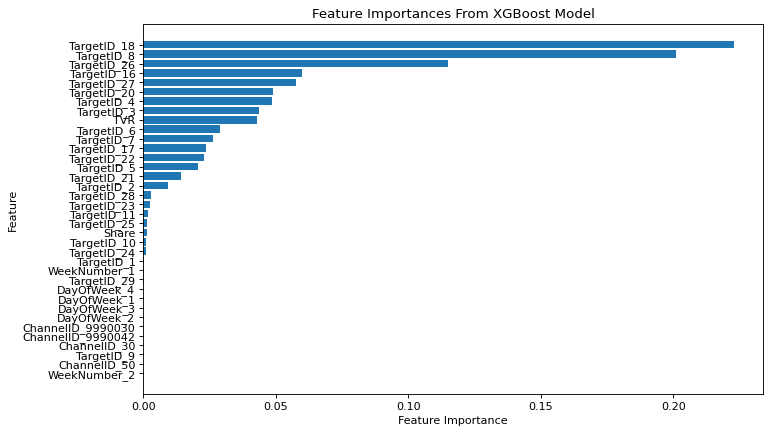

In [ ]:
from xgboost import plot_tree

fitted_pipeline = search.best_estimator_

preprocessor = fitted_pipeline.named_steps['preprocessor']
fitted_regressor = fitted_pipeline.named_steps['regressor']

cat_features = preprocessor.transformers_[1][2]
num_features = preprocessor.transformers_[2][2]

enc1 = preprocessor.named_transformers_['cat']
enc_cat_feat = enc1.get_feature_names_out(cat_features)

features = list(enc_cat_feat)+list(num_features)
importances = fitted_regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature':features,
    'Importance':importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances From XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

<Figure size 1600x1600 with 0 Axes>

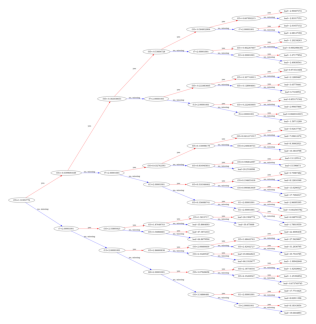

In [ ]:
plt.figure(figsize=(20, 20))
plot_tree(fitted_regressor, num_trees=0, fmap='', rankdir='LR')
plt.show()

# Advanced Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# Add ViewershipCategory column to model a classification tree

#mean_views = c2['Views'].mean()
#std_views = c2['Views'].std()

q1 = c2['Views'].quantile(0.25)
q2 = c2['Views'].quantile(0.50)
q3 = c2['Views'].quantile(0.75)

#c3 = c2.with_columns([
#    pl.when(pl.col('Views') < mean_views - 1.5 * std_views)
#    .then(1)  # Very Low Viewership
#    .when((pl.col('Views') >= mean_views - 1.5 * std_views) & (pl.col('Views') < mean_views - 0.5 * std_views))
#    .then(2)  # Low Viewership
#    .when((pl.col('Views') >= mean_views - 0.5 * std_views) & (pl.col('Views') < mean_views + 0.5 * std_views))
#    .then(3)  # Medium Viewership
#    .when((pl.col('Views') >= mean_views + 0.5 * std_views) & (pl.col('Views') < mean_views + 1.5 * std_views))
#    .then(4)  # High Viewership
#    .otherwise(5)  # Very High Viewership
#    .alias('ViewershipCategory')
#])

c3 = c2.with_columns([
    pl.when(pl.col('Views') < q1).then(0) # Low viewership
    .when((pl.col('Views') >= q1) & (pl.col('Views') <= q2)).then(1) # Medium viewership
    .when((pl.col('Views') >= q2) & (pl.col('Views') <= q3)).then(2) # High viewership
    .otherwise(3) # Very high viewership
    .alias('ViewershipCategory')
])

c3.glimpse()


Rows: 161280
Columns: 9
$ ChannelID          <i64> 50, 50, 30, 50, 30, 50, 50, 50, 50, 30
$ TargetID           <i64> 3, 7, 6, 16, 1, 21, 3, 28, 17, 1
$ Time               <str> '10:50', '10:30', '10:00', '13:25', '18:30', '24:20', '11:55', '16:55', '06:20', '10:10'
$ DayOfWeek          <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ WeekNumber         <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ Views              <f64> 33.0, 124.0, 305.4, 41.6, 96.2, 77.1, 16.9, 60.0, 0.0, 69.6
$ Share              <f64> 7.9652, 6.6972, 23.4202, 1.5643, 13.2561, 6.4735, 4.13, 2.6012, 0.0, 38.7312
$ TVR                <f64> 0.4065, 0.5442, 1.0538, 0.1332, 0.6772, 0.3088, 0.2082, 0.3589, 0.0, 0.49
$ ViewershipCategory <i32> 1, 2, 3, 1, 2, 2, 1, 2, 0, 2



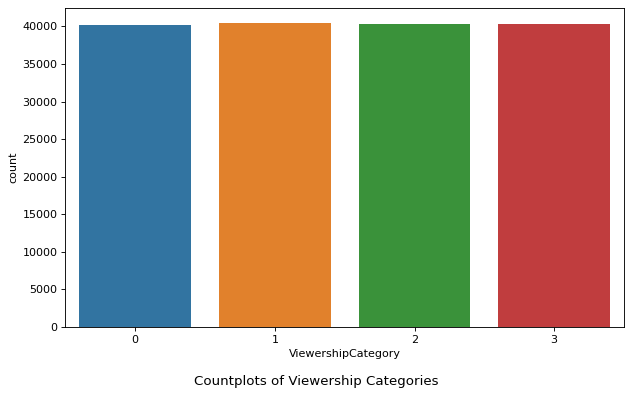

In [ ]:
cfm = c3.to_pandas()

cfmf = cfm[(cm['Share']>=0) & (cm['Views']>=0) & (cm['TVR']>=0)]
#cmf.info()

X2= cfmf.drop(columns=["ViewershipCategory"])
y2= cfmf["ViewershipCategory"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.2,random_state=42)

X2_test_copy = X2_test
X2_train_copy = X2_train
y2_train_copy = y2_train
y2_test_copy = y2_test

sns.countplot(data=cfm, x = cfm['ViewershipCategory'])
plt.suptitle("Countplots of Viewership Categories", y = -0.01, fontsize = 12)
plt.tight_layout()
plt.show()

## 1. Multi-class logistic regression (one vs. rest)

In [ ]:
columns_to_drop1 = ["Time","Views"]
catf1 = ["TargetID","ChannelID","DayOfWeek","WeekNumber"]
numf1 = ["Share","TVR"]

#pipelines to follow

prep2 = ColumnTransformer(
    transformers =[
            ("drop_columns", "drop", columns_to_drop1),
            ("cat", OneHotEncoder(),catf1),
            ("num", StandardScaler(),numf1)
        ])

log_pipe = Pipeline(
            steps =[
                ('preprocessor', prep2),
                ('Logistic_regressor', LogisticRegression(solver="saga",multi_class='ovr', max_iter=1000))
            ])

log_pipe.fit(X2_train,y2_train)

y_class1 = log_pipe.predict(X2_test)

log_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['Time', 'Views']),
                                                 ('cat', OneHotEncoder(),
                                                  ['TargetID', 'ChannelID',
                                                   'DayOfWeek', 'WeekNumber']),
                                                 ('num', StandardScaler(),
                                                  ['Share', 'TVR'])])),
                ('Logistic_regressor',
                 LogisticRegression(max_iter=1000, multi_class='ovr',
                                    solver='saga'))])

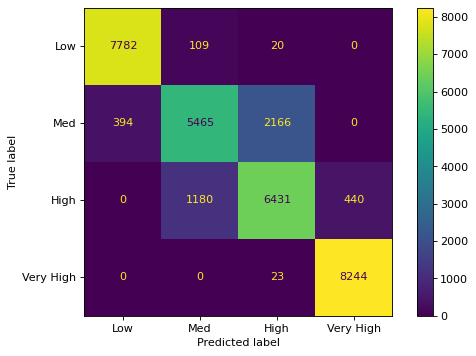

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7911
           1       0.81      0.68      0.74      8025
           2       0.74      0.80      0.77      8051
           3       0.95      1.00      0.97      8267

    accuracy                           0.87     32254
   macro avg       0.86      0.87      0.86     32254
weighted avg       0.86      0.87      0.86     32254

F1 score: 0.8629644278517168
Recall score: 0.8656910770757116


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_class1),display_labels=["Low", "Med", "High","Very High"])
cmp.plot(ax=ax)
plt.show()
print(classification_report(y2_test, y_class1))

print(f"F1 score:", f1_score(y2_test, y_class1, average = 'weighted'))
print(f"Recall score:", recall_score(y2_test, y_class1, average = 'weighted'))

In [ ]:
RRSE4 = rrse(y2_test,y_class1)
print(f'RRSE:{RRSE4}')

RRSE:0.32967463975750033


In [ ]:
'''
svc_model = SVC(gamma='auto')
ovo_model = OneVsOneClassifier(svc_model)

ovo_pipe = Pipeline(
            steps =[
                ('preprocessor', prep2),
                ('ovo_classifier', ovo_model)
            ])

ovo_pipe.fit(X2_train,y2_train)

y_class2 = ovo_pipe.predict(X2_test)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_class2),display_labels=["Low", "Med", "High","Very High"])
cmp.plot(ax=ax)
plt.show()
print(classification_report(y2_test, y_class2))
'''

'\nsvc_model = SVC(gamma=\'auto\')\novo_model = OneVsOneClassifier(svc_model)\n\novo_pipe = Pipeline(\n            steps =[\n                (\'preprocessor\', prep2),\n                (\'ovo_classifier\', ovo_model)\n            ])\n\novo_pipe.fit(X2_train,y2_train)\n\ny_class2 = ovo_pipe.predict(X2_test)\n\nfig, ax = plt.subplots(figsize=(8, 5))   \ncmp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_class2),display_labels=["Low", "Med", "High","Very High"])\ncmp.plot(ax=ax)            \nplt.show()\nprint(classification_report(y2_test, y_class2))\n'

In [ ]:
#RRSE5 = rrse(y2_test,y_class2)
#print(f'RRSE:{RRSE4}')

## 2. Decision Tree Classifier

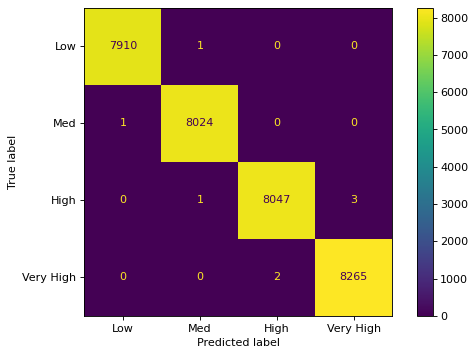

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7911
           1       1.00      1.00      1.00      8025
           2       1.00      1.00      1.00      8051
           3       1.00      1.00      1.00      8267

    accuracy                           1.00     32254
   macro avg       1.00      1.00      1.00     32254
weighted avg       1.00      1.00      1.00     32254

F1 score: 0.9997519647788103
Recall score: 0.9997519687480623
RRSE:0.014070170755850599


In [ ]:
tree_pipe = Pipeline(
            steps =[
                ('preprocessor', prep2),
                ('Decision_Tree', DecisionTreeClassifier())
            ])

tree_pipe.fit(X2_train,y2_train)

y_class3 = tree_pipe.predict(X2_test)

fig, ax = plt.subplots(figsize=(8, 5))

cmp3 = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_class3),display_labels=["Low", "Med","High","Very High"])

cmp3.plot(ax=ax)
plt.show()
print(classification_report(y2_test, y_class3))

print(f"F1 score:", f1_score(y2_test, y_class3, average = 'weighted'))
print(f"Recall score:", recall_score(y2_test, y_class3, average = 'weighted'))
print(f'RRSE:{rrse(y2_test, y_class3)}')

In [ ]:
'''
xgb_pipe2 = Pipeline(steps=[
    ('preprocessor', prep2),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

param_grid2 = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(
    estimator=xgb_pipe2,
    param_grid=param_grid2,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X2_train, y2_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)
'''

'\nxgb_pipe2 = Pipeline(steps=[\n    (\'preprocessor\', prep2),\n    (\'classifier\', XGBClassifier(use_label_encoder=False, eval_metric=\'logloss\'))\n])\n\nparam_grid2 = {\n    \'classifier__max_depth\': [3, 4, 5],\n    \'classifier__n_estimators\': [100, 200, 300],\n    \'classifier__learning_rate\': [0.01, 0.1, 0.2],\n    \'classifier__colsample_bytree\': [0.3, 0.5, 0.7]\n}\n\ngrid_search = GridSearchCV(\n    estimator=xgb_pipe2,\n    param_grid=param_grid2,\n    cv=3,\n    n_jobs=-1,\n    verbose=1\n)\n\n# Fit the model\ngrid_search.fit(X2_train, y2_train)\n\nbest_model = grid_search.best_estimator_\nbest_params = grid_search.best_params_\n\nprint("Best Parameters:", best_params)\nprint("Best Score:", grid_search.best_score_)\n'

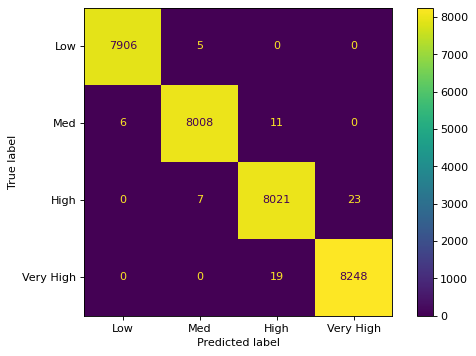

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7911
           1       1.00      1.00      1.00      8025
           2       1.00      1.00      1.00      8051
           3       1.00      1.00      1.00      8267

    accuracy                           1.00     32254
   macro avg       1.00      1.00      1.00     32254
weighted avg       1.00      1.00      1.00     32254

F1 score: 0.9977987507988213
Recall score: 0.9977987226390526
RRSE:0.04191635877258176


In [ ]:
xgb2 = XGBClassifier(eval_metric = 'mlogloss')
xgb_pipe2 = Pipeline(
            steps =[
                ('preprocessor', prep2),
                ('XG_Boost', xgb2)
            ])

xgb_pipe2.fit(X2_train,y2_train)

y_prob = xgb_pipe2.predict_proba(X2_test)
y_class3 = xgb_pipe2.predict(X2_test)

fig, ax = plt.subplots(figsize=(8, 5))

cmp3 = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_class3),display_labels=["Low", "Med","High","Very High"])

cmp3.plot(ax=ax)
plt.show()
print(classification_report(y2_test, y_class3))

print(f"F1 score:", f1_score(y2_test, y_class3, average = 'weighted'))
print(f"Recall score:", recall_score(y2_test, y_class3, average = 'weighted'))
print(f'RRSE:{rrse(y2_test, y_class3)}')

xgb2_tree = xgb_pipe2.named_steps['XG_Boost']


<Figure size 800000x800000 with 0 Axes>

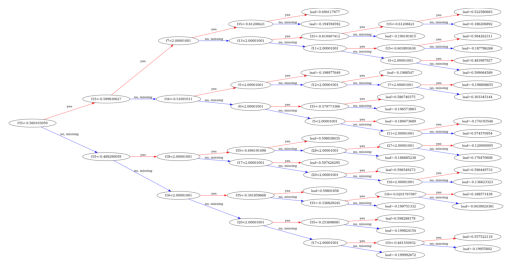

In [ ]:
plt.figure(figsize=(10000, 10000))
plot_tree(xgb2_tree, num_trees =0,rankdir = 'LR')
plt.show()
fig.savefig("xgb_class_tree.png")

In [ ]:
y_prob_df = pd.DataFrame(y_prob, columns=['Low','Medium','High','VeryHigh'])
result_df = pd.concat([X2_test_copy.reset_index(drop=True),y_prob_df], axis= 1)
print(result_df.head())

   ChannelID  TargetID   Time  DayOfWeek  WeekNumber  Views    Share     TVR  \
0    9990042        11  18:25          1           1   10.5   2.1016  0.1308   
1    9990042        24  22:55          2           2    2.3   4.1666  0.0484   
2         30        22  07:10          2           2   12.6  11.1111  0.5798   
3         50        24  16:10          2           2    0.0   0.0000  0.0000   
4         50         6  15:25          3           2   67.8   3.8595  0.2339   

        Low    Medium          High      VeryHigh  
0  0.006887  0.993070  1.479995e-05  2.799334e-05  
1  0.999749  0.000251  6.358453e-08  1.186493e-07  
2  0.000063  0.999531  4.020143e-04  3.622884e-06  
3  0.999997  0.000003  8.653164e-09  2.559501e-08  
4  0.000019  0.001398  9.985606e-01  2.244010e-05  


Index(['ChannelID', 'TargetID', 'Time', 'DayOfWeek', 'WeekNumber', 'Views',
       'Share', 'TVR'],
      dtype='object')
Index(['ChannelID', 'TargetID', 'Time', 'DayOfWeek', 'WeekNumber', 'Views',
       'Share', 'TVR'],
      dtype='object')
Index(['ChannelID', 'TargetID', 'Time', 'DayOfWeek', 'WeekNumber', 'Views',
       'Share', 'TVR'],
      dtype='object')


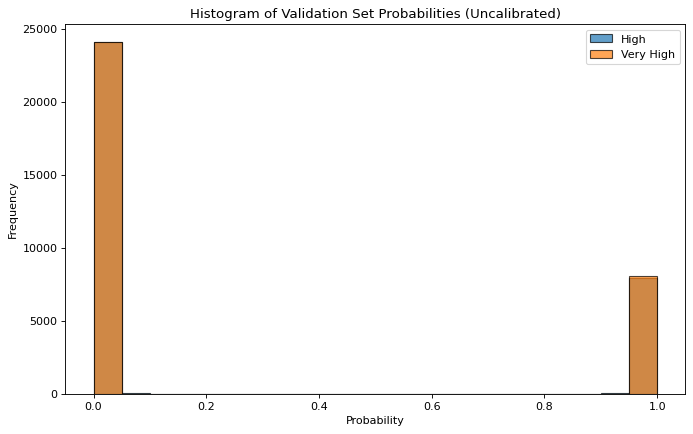

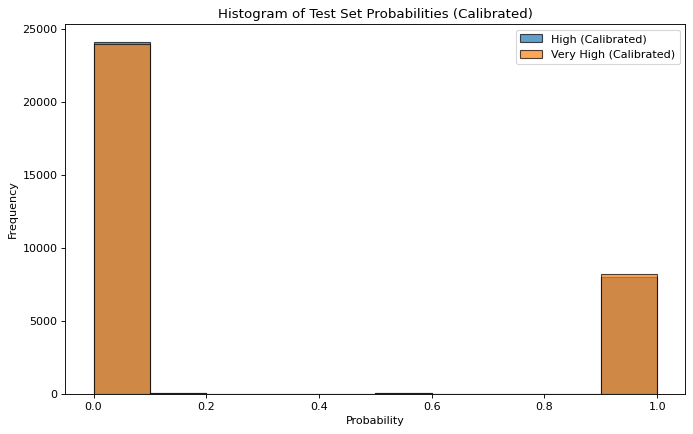

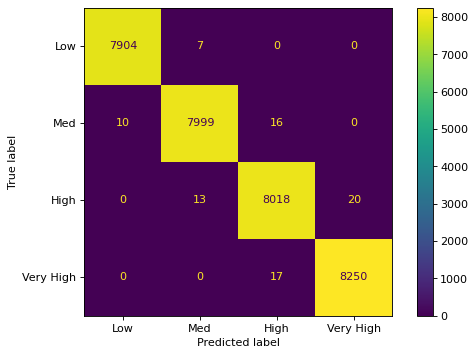

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7911
           1       1.00      1.00      1.00      8025
           2       1.00      1.00      1.00      8051
           3       1.00      1.00      1.00      8267

    accuracy                           1.00     32254
   macro avg       1.00      1.00      1.00     32254
weighted avg       1.00      1.00      1.00     32254

F1 score: 0.9974265630972484
Recall score: 0.9974266757611459


In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression

X_train_val, X3_test, y_train_val, y3_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X_val, y3_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(X3_train.columns)
print(X_val.columns)
print(X3_test.columns)


xgb3 = XGBClassifier(eval_metric='mlogloss')
xgb_pipe3 = Pipeline(
    steps=[
        ('preprocessor', prep2),
        ('XG_Boost', xgb3)
    ]
)

xgb_pipe3.fit(X3_train, y3_train)

# Evaluate uncalibrated probabilities on the validation dataset
y_val_prob = xgb_pipe3.predict_proba(X_val)

# Visualize the histogram of the uncalibrated probability distribution (for class 'high' and 'very high')
plt.figure(figsize=(10, 6))
plt.hist(y_val_prob[:, 2], bins=20, edgecolor='k', alpha=0.7, label="High")
plt.hist(y_val_prob[:, 3], bins=20, edgecolor='k', alpha=0.7, label="Very High")
plt.title('Histogram of Validation Set Probabilities (Uncalibrated)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calibrate the probabilities using Isotonic Regression
iso_reg = IsotonicRegression(out_of_bounds='clip')
y_val_prob_calibrated_high = iso_reg.fit_transform(y_val_prob[:, 2], y_val == 2)
y_val_prob_calibrated_very_high = iso_reg.fit_transform(y_val_prob[:, 3], y_val == 3)

# Evaluate calibrated probabilities on the test set
y_test_prob = xgb_pipe3.predict_proba(X3_test)
y_test_prob_calibrated_high = iso_reg.transform(y_test_prob[:, 2])
y_test_prob_calibrated_very_high = iso_reg.transform(y_test_prob[:, 3])

plt.figure(figsize=(10, 6))
plt.hist(y_test_prob_calibrated_high, bins=10, edgecolor='k', alpha=0.7, label="High (Calibrated)")
plt.hist(y_test_prob_calibrated_very_high, bins=10, edgecolor='k', alpha=0.7, label="Very High (Calibrated)")
plt.title('Histogram of Test Set Probabilities (Calibrated)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

y_class4 = xgb_pipe3.predict(X3_test)

fig, ax = plt.subplots(figsize=(8, 5))
cmp4 = ConfusionMatrixDisplay(confusion_matrix(y3_test, y_class4), display_labels=["Low", "Med", "High", "Very High"])
cmp4.plot(ax=ax)
plt.show()

print(classification_report(y3_test, y_class4))
print(f"F1 score:", f1_score(y3_test, y_class4, average='weighted'))
print(f"Recall score:", recall_score(y3_test, y_class4, average='weighted'))

xgb3_tree = xgb_pipe3.named_steps['XG_Boost']

# Optimizing slot selection

In [ ]:
result = pl.from_pandas(result_df)
n_t = []
hour = []
minutes =[]

def normalize_time(time_str):
    hour, minute = map(int, time_str.split(':'))
    normalized_hour = hour % 24
    return f"{normalized_hour:02d}:{minute:02d}"

def extract_hour(time_str):
    hour, _ = map(int, time_str.split(':'))
    return hour % 24

def extract_min(time_str):
    _, minute = map(int, time_str.split(':'))
    return minute

for time_str in result['Time']:
    n_t.append(normalize_time(time_str))
    hour.append(extract_hour(time_str))
    minutes.append(extract_min(time_str))

result = result.with_columns([
    pl.Series('NormalizedTime', n_t),
    pl.Series('Hour', hour),
    pl.Series('Min',minutes)
])

result =result.with_columns([
    ((pl.col('Hour') % 24) * 4 + pl.col('Min') // 15).alias('Slot')
])

result.glimpse()

Rows: 32254
Columns: 16
$ ChannelID      <i64> 9990042, 9990042, 30, 50, 50, 9990030, 9990042, 50, 50, 9990042
$ TargetID       <i64> 11, 24, 22, 24, 6, 11, 8, 24, 11, 11
$ Time           <str> '18:25', '22:55', '07:10', '16:10', '15:25', '24:30', '24:15', '23:20', '14:25', '21:50'
$ DayOfWeek      <i64> 1, 2, 2, 2, 3, 1, 1, 2, 3, 1
$ WeekNumber     <i64> 1, 2, 2, 2, 2, 1, 1, 1, 2, 1
$ Views          <f64> 10.5, 2.3, 12.6, 0.0, 67.8, 0.0, 169.5, 0.0, 0.0, 109.7
$ Share          <f64> 2.1016, 4.1666, 11.1111, 0.0, 3.8595, 0.0, 6.4561, 0.0, 0.0, 16.8925
$ TVR            <f64> 0.1308, 0.0484, 0.5798, 0.0, 0.2339, 0.0, 0.2784, 0.0, 0.0, 1.3666
$ Low            <f32> 0.006887007504701614, 0.9997487664222717, 6.329866300802678e-05, 0.9999972581863403, 1.8783879568218254e-05, 0.9999974966049194, 4.863520643993979e-06, 0.9999972581863403, 0.9999966621398926, 1.7541040051582968e-06
$ Medium         <f32> 0.9930701851844788, 0.0002510878548491746, 0.9995310306549072, 2.754689376160968e-06, 0.001

In [ ]:
!pip install pulp
!pip install pandas openpyxl

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/tmp/ipykernel_34/1192664108.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df['Combined Prob'] = f_df['High'] + f_df['VeryHigh']


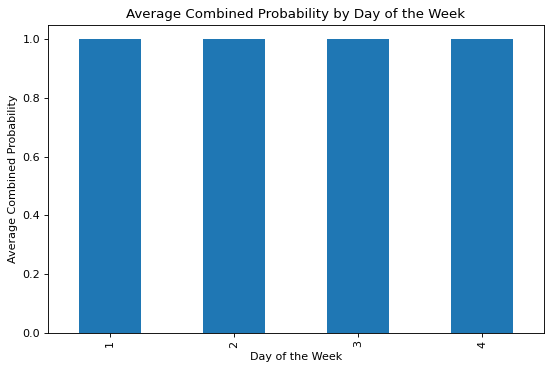

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/80644e263c0147b2bc3ba2e8e8748670-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/80644e263c0147b2bc3ba2e8e8748670-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 157931 COLUMNS
At line 481172 RHS
At line 639099 BOUNDS
At line 640584 ENDATA
Problem MODEL has 157926 rows, 1484 columns and 318788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.41 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.85   (Wallclock seconds):       0.95

Problem not solved to optimality
File saved to: /kaggle/working/selected_slots.xlsx


In [ ]:
import pulp as plp

results_df = result.to_pandas()

# Parameters
target_IDs = [11, 16, 17, 20, 21]
tvr_threshold = 1.5
min_slots = 10
max_slots = 10

slots_per_day = 96
num_days = 4
num_weeks = 2

# Initialize a list to hold distance matrices for each day
distance_matrices = []

# Create distance matrices for each day
for day in range(num_days):
    dist_mat = np.zeros((slots_per_day, slots_per_day))
    for i in range(slots_per_day):
        for j in range(slots_per_day):
            dist_mat[i, j] = abs(i - j)
    distance_matrices.append(dist_mat)


f_df = results_df[(results_df['TargetID'].isin(target_IDs)) & (results_df['TVR'] >= tvr_threshold)]

f_df['Combined Prob'] = f_df['High'] + f_df['VeryHigh']


f_df.groupby('DayOfWeek')['Combined Prob'].mean().plot(kind='bar')
plt.title('Average Combined Probability by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Combined Probability')
plt.show()


obj = plp.LpProblem("Slot_Selection", plp.LpMaximize)


slot_vars = plp.LpVariable.dicts("slot", [(week, day, slot_num)
                                          for week in range(num_weeks)
                                          for day in range(num_days)
                                          for slot_num in f_df.index],
                                 cat='Binary')

# Constraint: Minimum slots per day
for week in range(num_weeks):
    for day in range(num_days):
        day_slots = f_df[(f_df['DayOfWeek'] == day + 1) & (f_df['WeekNumber'] == week + 1)].index
        obj += plp.lpSum([slot_vars[(week, day, slot_num)] for slot_num in day_slots]) >= min_slots, f"MinSlotsWeek{week + 1}_Day{day + 1}"

# Constraint: Maximum slots per day
for week in range(num_weeks):
    for day in range(num_days):
        day_slots = f_df[(f_df['DayOfWeek'] == day + 1) & (f_df['WeekNumber'] == week + 1)].index
        obj += plp.lpSum([slot_vars[(week, day, slot_num)] for slot_num in day_slots]) <= max_slots, f"MaxSlotsWeek{week+1}_Day{day+1}"

# Constraint: Distance
for week in range(num_weeks):
    for day in range(num_days):
        day_slots = f_df[(f_df['DayOfWeek'] == day + 1) & (f_df['WeekNumber'] == week + 1)].index
        dist_mat = distance_matrices[day]


        day_slots_mapped = {slot_num: idx for idx, slot_num in enumerate(day_slots)}

        for i in day_slots:
            for j in day_slots:
                if i < j:
                    idx_i = (i - 1) % slots_per_day
                    idx_j = (j - 1) % slots_per_day
                    obj += slot_vars[(week, day, i)] + slot_vars[(week, day, j)] <= 1 + (1 - dist_mat[idx_i, idx_j] / np.max(dist_mat)), f"DistConstraint_Week{week+1}_Day{day+1}_{i}_{j}"

# Objective function: Maximize combined probability
obj += plp.lpSum([slot_vars[(week, day, slot_num)] * f_df.loc[slot_num]['Combined Prob']
                  for week in range(num_weeks)
                  for day in range(num_days)
                  for slot_num in f_df[(f_df['DayOfWeek'] == day + 1) & (f_df['WeekNumber'] == week + 1)].index]), "MaximizeCombinedProbability"


obj.solve()

if plp.LpStatus[obj.status] == 'Optimal':
    print(f"Objective Value = {plp.value(obj.objective)}")
else:
    print("Problem not solved to optimality")

selected_slots = [slot_num for slot_num in f_df.index if slot_vars[(week, day, slot_num)].value() == 1]

selected_df = f_df.loc[selected_slots]

output_file_path = '/kaggle/working/selected_slots.xlsx'
selected_df.to_excel(output_file_path, index=False)  # Set index=False to not include DataFrame indices

print(f"File saved to: {output_file_path}")
